# Thrust Map Data Visualization

This notebook loads raw thrust map CSV files, creates structured dataframes with proper headers, and generates visualizations and exports for LaTeX plotting.

**Workflow:**
1. Load raw CSV files (cmd_data.csv, force_data.csv, etc.)
2. Create structured DataFrame with proper headers
3. Visualizations and data exploration
4. Export formatted CSVs for LaTeX

## 1. Import Required Libraries

In [66]:
import os
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.neighbors import LocalOutlierFactor

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 2. Configuration and Hyperparameters

In [67]:
# Configuration
data_dir = Path('../logs/thrust_map')  # Directory containing raw CSV files
output_dir = Path('./data')
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Output directory: {output_dir}")

Data directory: ../logs/thrust_map
Output directory: data


## 3. Load Raw CSV Files

Load the individual CSV files:
- `cmd_data.csv`: Motor command values (1 column)
- `force_data.csv`: 3D force measurements (3 columns: x, y, z)
- `rpm_data.csv`: RPM data (if available)
- `torque_data.csv`: 3D torque measurements (3 columns: x, y, z)
- `voltage_data.csv`: Battery voltage measurements (1 column)

In [68]:
# Load raw CSV files
print("Loading raw CSV files...")

# Load command data (single column)
cmd_file = data_dir / 'cmd_data.csv'
cmd_data = np.loadtxt(cmd_file, delimiter=',')
if cmd_data.ndim == 1:
    cmd_data = cmd_data[:, np.newaxis]
print(f"  ✓ Loaded cmd_data.csv: shape {cmd_data.shape}")

# Load force data (3 columns: x, y, z)
force_file = data_dir / 'force_data.csv'
force_data = np.loadtxt(force_file, delimiter=',')
if force_data.ndim == 1:
    force_data = force_data[:, np.newaxis]
print(f"  ✓ Loaded force_data.csv: shape {force_data.shape}")

# Load voltage data (single column) - if exists
voltage_file = data_dir / 'voltage_data.csv'
if voltage_file.exists():
    voltage_data = np.loadtxt(voltage_file, delimiter=',')
    if voltage_data.ndim == 1:
        voltage_data = voltage_data[:, np.newaxis]
    print(f"  ✓ Loaded voltage_data.csv: shape {voltage_data.shape}")
else:
    # Create placeholder voltage data if not available
    voltage_data = np.zeros((len(cmd_data), 1))
    print(f"  ⚠ voltage_data.csv not found, using placeholder zeros")

# Load torque data (3 columns) - if exists
torque_file = data_dir / 'torque_data.csv'
if torque_file.exists():
    torque_data = np.loadtxt(torque_file, delimiter=',')
    if torque_data.ndim == 1:
        torque_data = torque_data[:, np.newaxis]
    print(f"  ✓ Loaded torque_data.csv: shape {torque_data.shape}")
else:
    torque_data = np.zeros((len(cmd_data), 3))
    print(f"  ⚠ torque_data.csv not found, using placeholder zeros")

# Load RPM data - if exists
rpm_file = data_dir / 'rpm_data.csv'
if rpm_file.exists():
    rpm_data = np.loadtxt(rpm_file, delimiter=',')
    if rpm_data.ndim == 1:
        rpm_data = rpm_data[:, np.newaxis]
    print(f"  ✓ Loaded rpm_data.csv: shape {rpm_data.shape}")
else:
    rpm_data = None
    print(f"  ⚠ rpm_data.csv not found")

print(f"\n✓ All data loaded successfully!")
print(f"Total data points: {len(cmd_data)}")

Loading raw CSV files...
  ✓ Loaded cmd_data.csv: shape (975, 1)
  ✓ Loaded force_data.csv: shape (975, 3)
  ✓ Loaded voltage_data.csv: shape (975, 1)
  ✓ Loaded torque_data.csv: shape (975, 3)
  ✓ Loaded rpm_data.csv: shape (975, 4)

✓ All data loaded successfully!
Total data points: 975


## 4. Create Structured DataFrame with Headers

Convert raw numpy arrays to a structured pandas DataFrame with proper column names.

In [69]:
# Create DataFrame with proper column headers
print("Creating structured DataFrame...")

# Build dictionary for DataFrame
data_dict = {
    'cmd': cmd_data.flatten(),
}

# Add voltage if available
if voltage_data is not None:
    data_dict['voltage_V'] = voltage_data.flatten()

# Add force data (handle both single column and 3 columns)
if force_data.shape[1] == 3:
    data_dict['force_x_N'] = force_data[:, 0]
    data_dict['force_y_N'] = force_data[:, 1]
    data_dict['force_z_N'] = force_data[:, 2]
else:
    # If only one column, assume it's the z-axis (thrust)
    data_dict['force_z_N'] = force_data.flatten()

# Add torque data if available
if torque_data is not None and torque_data.shape[1] >= 3:
    data_dict['torque_x_Nm'] = torque_data[:, 0]
    data_dict['torque_y_Nm'] = torque_data[:, 1]
    data_dict['torque_z_Nm'] = torque_data[:, 2]

# Add RPM data if available
if rpm_data is not None:
    if rpm_data.shape[1] == 4:
        data_dict['rpm_motor1'] = rpm_data[:, 0]
        data_dict['rpm_motor2'] = rpm_data[:, 1]
        data_dict['rpm_motor3'] = rpm_data[:, 2]
        data_dict['rpm_motor4'] = rpm_data[:, 3]
    else:
        data_dict['rpm'] = rpm_data.flatten()

# Create DataFrame
df_raw = pd.DataFrame(data_dict)

# Display first few rows
print("\n" + "="*80)
print("Raw data DataFrame (first 10 rows):")
print("="*80)
print(df_raw.head(10))

# Summary statistics
print("\n" + "="*80)
print("Summary Statistics:")
print("="*80)
print(df_raw.describe())

# Export raw data to CSV
raw_data_file = output_dir / 'thrust_map_raw_data.csv'
df_raw.to_csv(raw_data_file, index=False)
print(f"\n✓ Saved raw data with headers to: {raw_data_file}")

Creating structured DataFrame...

Raw data DataFrame (first 10 rows):
     cmd  voltage_V  force_x_N  force_y_N  force_z_N  torque_x_Nm  \
0  0.055       15.5  11.937124  12.725542  -0.388082     0.238251   
1  0.055       15.5  12.429455  12.877916  -0.451430     0.243462   
2  0.055       15.5  11.465699  13.421498  -0.505959     0.255334   
3  0.055       15.5  12.418451  12.641342  -0.525808     0.236536   
4  0.055       15.5  12.891815  12.912231  -0.435871     0.244316   
5  0.055       15.5  11.264334  13.398027  -0.537052     0.253544   
6  0.055       15.5  12.373302  12.739308  -0.417054     0.238676   
7  0.055       15.5  12.749748  12.895841  -0.398518     0.243736   
8  0.055       15.5  11.315443  13.456856  -0.535658     0.253775   
9  0.055       15.5  12.442739  12.647466  -0.460557     0.236542   

   torque_y_Nm  torque_z_Nm  rpm_motor1  rpm_motor2  rpm_motor3  rpm_motor4  
0    -0.189489     0.241261       3.914         0.0         0.0         0.0  
1    -0.193807

Creating verification plots...


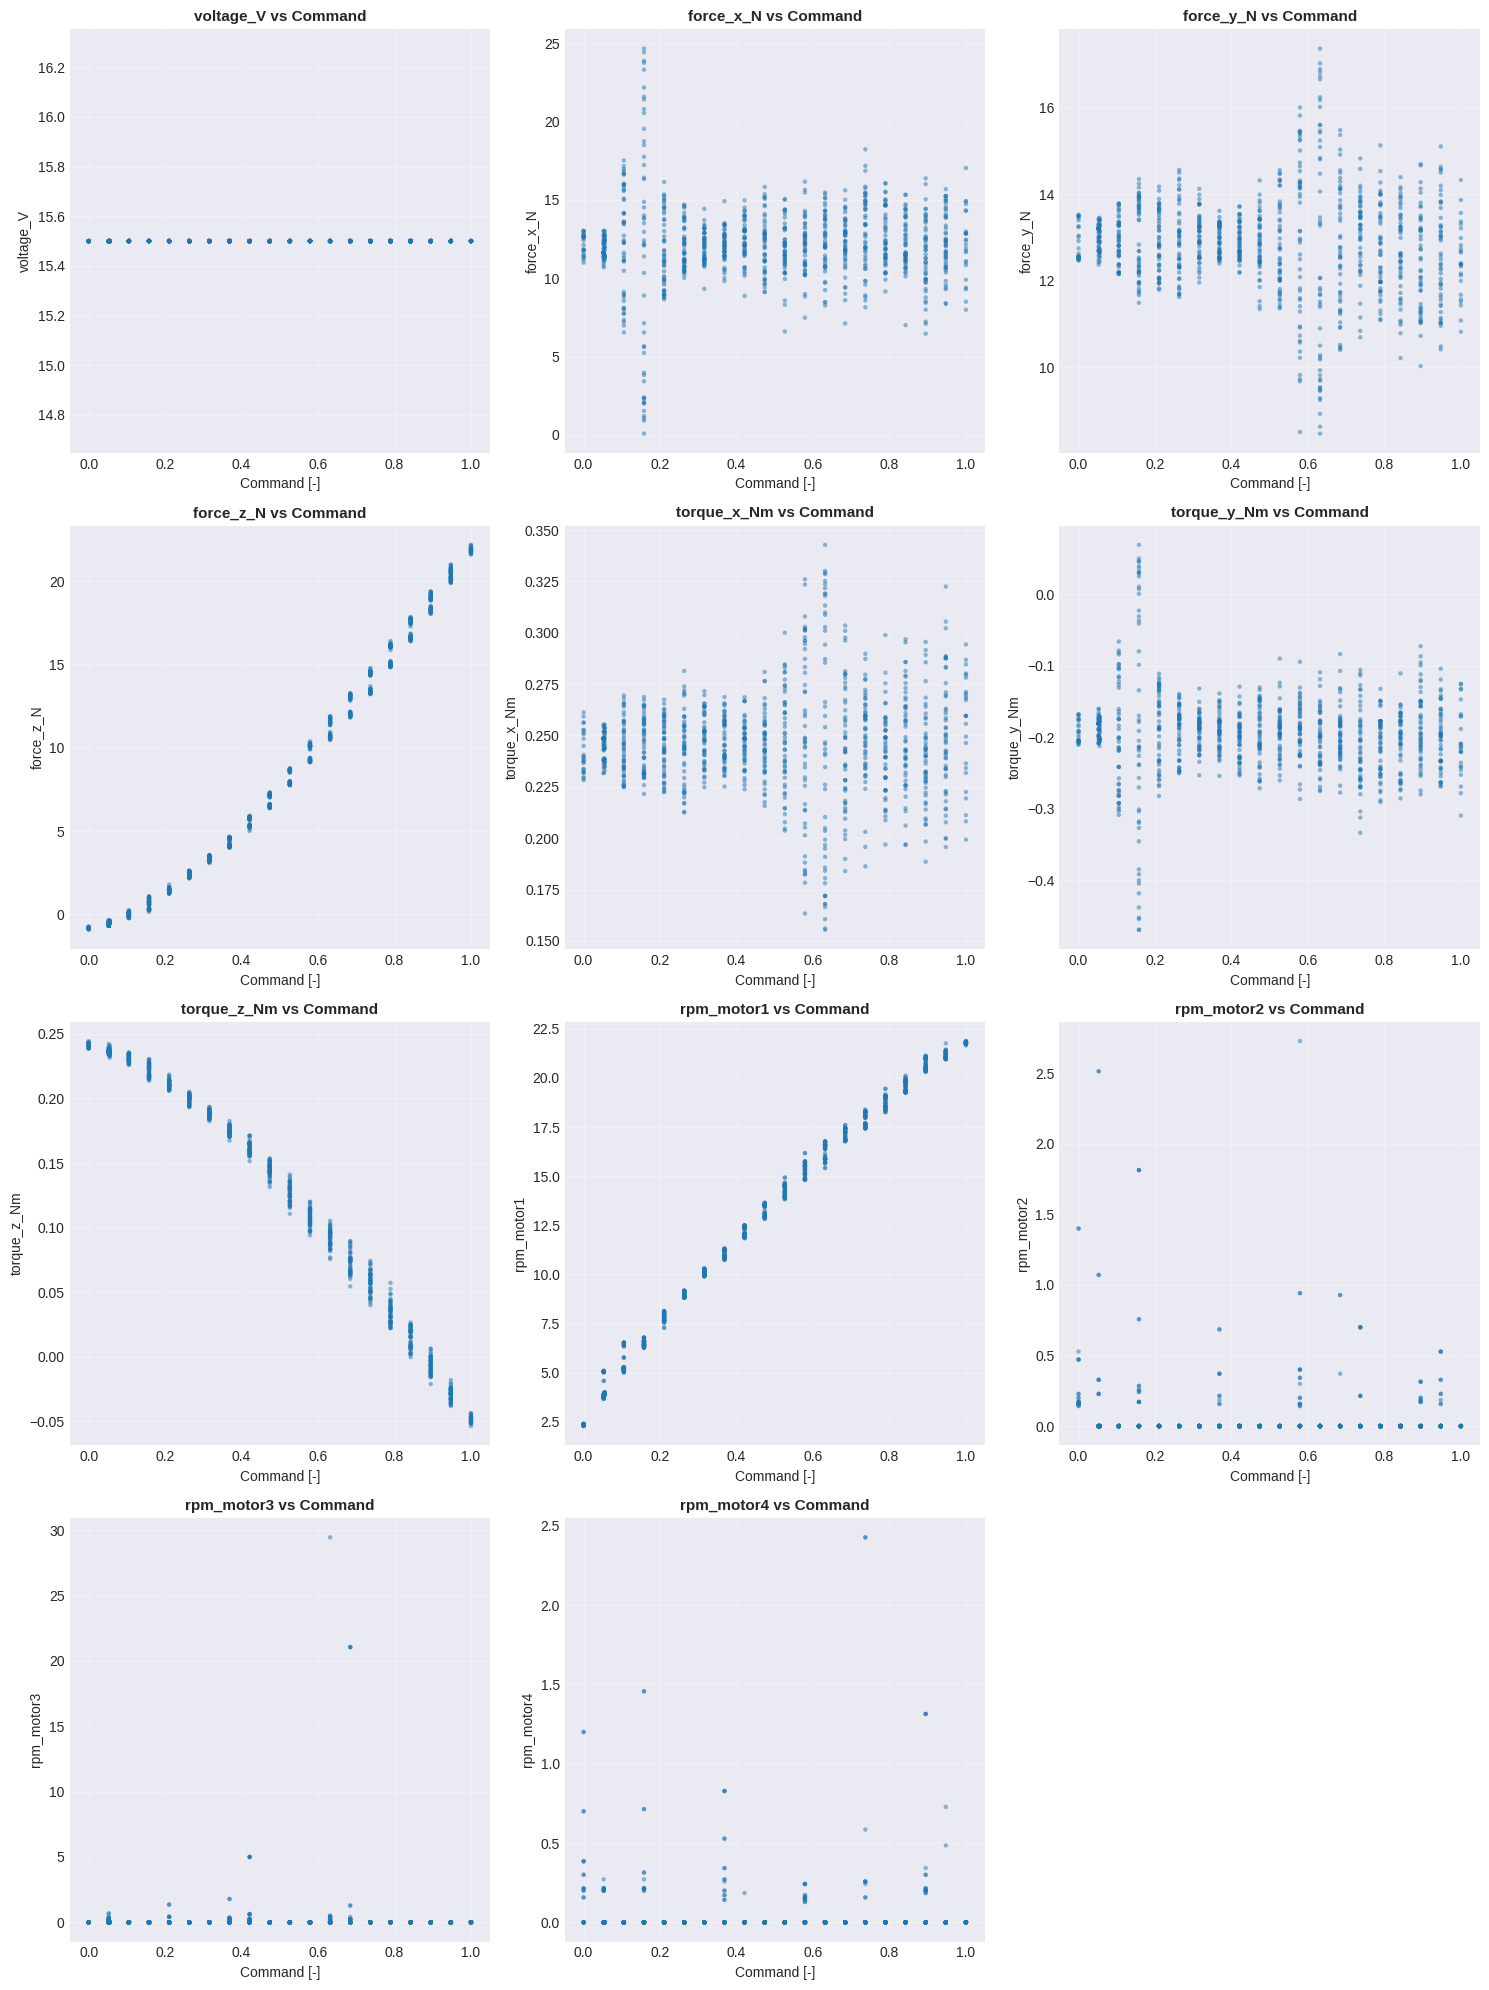

✓ Verification plot saved: verification_all_vs_cmd.png
✓ Plotted 11 columns against command


In [70]:
# Plot all columns vs command for verification
print("Creating verification plots...")

# Get all columns except 'cmd'
plot_cols = [col for col in df_raw.columns if col != 'cmd']

# Calculate grid dimensions
n_cols = len(plot_cols)
n_rows = (n_cols + 2) // 3  # 3 plots per row
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))

# Flatten axes array for easy iteration
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Plot each column
for idx, col in enumerate(plot_cols):
    ax = axes[idx]
    ax.scatter(df_raw['cmd'], df_raw[col], alpha=0.5, s=10, edgecolors='none')
    ax.set_xlabel('Command [-]', fontsize=10)
    ax.set_ylabel(col, fontsize=10)
    ax.set_title(f'{col} vs Command', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(plot_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(output_dir / 'verification_all_vs_cmd.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Verification plot saved: verification_all_vs_cmd.png")
print(f"✓ Plotted {len(plot_cols)} columns against command")

## 5. RPM Analysis and Fitted Models

Create specific plots with fitted functions:
1. Thrust over RPM (linear fit)
2. RPM over Command (quadratic fit)
3. Thrust over Command

In [71]:
# Check if RPM data is available
if rpm_data is not None and ('rpm' in df_raw.columns or 'rpm_motor1' in df_raw.columns):
    print("Creating RPM analysis plots with fitted models...")
    
    # Use only motor 1 RPM data
    if 'rpm_motor1' in df_raw.columns:
        rpm_col = 'rpm_motor1'
        print(f"  ✓ Using RPM from motor 1 only")
    else:
        rpm_col = 'rpm'
        print(f"  ✓ Using single RPM column")
    
    # Remove any NaN or zero values for fitting
    df_fit = df_raw[(df_raw[rpm_col] > 0) & (df_raw['force_z_N'].notna())].copy()
    
    print(f"  ✓ Using {len(df_fit)} data points for fitting")
    
else:
    print("⚠ Warning: RPM data not available. Skipping RPM analysis.")
    df_fit = None

Creating RPM analysis plots with fitted models...
  ✓ Using RPM from motor 1 only
  ✓ Using 975 data points for fitting


### 5.1 Thrust vs RPM (Quadratic Fit)

Fit a quadratic model: **Thrust = a × RPM² + b × RPM + c**

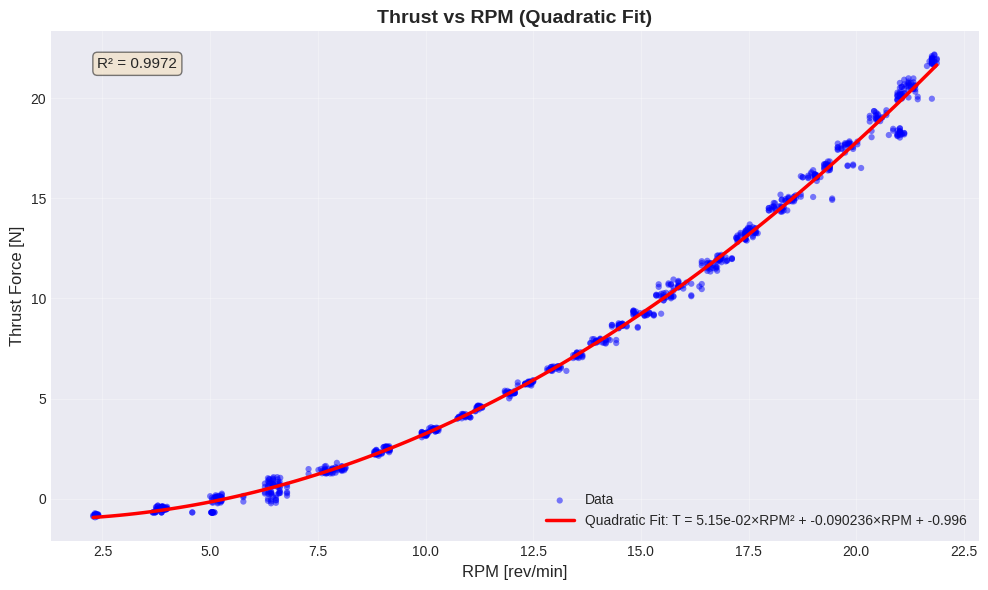

✓ Quadratic Fit Results:
  Thrust = 5.14747846e-02 × RPM² + -0.09023580 × RPM + -0.9959
  R² = 0.9972
  Saved: thrust_vs_rpm_quadratic.png/pdf
  ✓ Saved fit data: thrust_vs_rpm_quadratic_fit.csv


In [72]:
if df_fit is not None:
    # Quadratic fit: Thrust = a * RPM^2 + b * RPM + c
    coeffs_thrust = np.polyfit(df_fit[rpm_col], df_fit['force_z_N'], 2)
    a_thrust, b_thrust, c_thrust = coeffs_thrust
    
    # Generate fitted curve
    rpm_range = np.linspace(df_fit[rpm_col].min(), df_fit[rpm_col].max(), 100)
    thrust_fit_quad = a_thrust * rpm_range**2 + b_thrust * rpm_range + c_thrust
    
    # Calculate R²
    thrust_pred = a_thrust * df_fit[rpm_col]**2 + b_thrust * df_fit[rpm_col] + c_thrust
    ss_res = np.sum((df_fit['force_z_N'] - thrust_pred)**2)
    ss_tot = np.sum((df_fit['force_z_N'] - df_fit['force_z_N'].mean())**2)
    r2_thrust = 1 - (ss_res / ss_tot)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(df_fit[rpm_col], df_fit['force_z_N'], alpha=0.5, s=20, 
               c='blue', edgecolors='none', label='Data')
    ax.plot(rpm_range, thrust_fit_quad, 'r-', linewidth=2.5, 
            label=f'Quadratic Fit: T = {a_thrust:.2e}×RPM² + {b_thrust:.6f}×RPM + {c_thrust:.3f}')
    
    ax.set_xlabel('RPM [rev/min]', fontsize=12)
    ax.set_ylabel('Thrust Force [N]', fontsize=12)
    ax.set_title('Thrust vs RPM (Quadratic Fit)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add R² text
    ax.text(0.05, 0.95, f'R² = {r2_thrust:.4f}', 
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(output_dir / 'thrust_vs_rpm_quadratic.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'thrust_vs_rpm_quadratic.pdf', bbox_inches='tight')
    plt.show()
    
    print(f"✓ Quadratic Fit Results:")
    print(f"  Thrust = {a_thrust:.8e} × RPM² + {b_thrust:.8f} × RPM + {c_thrust:.4f}")
    print(f"  R² = {r2_thrust:.4f}")
    print(f"  Saved: thrust_vs_rpm_quadratic.png/pdf")
    
    # Export data with fit
    df_export = pd.DataFrame({
        'rpm': rpm_range,
        'thrust_N_fitted': thrust_fit_quad
    })
    df_export.to_csv(output_dir / 'thrust_vs_rpm_quadratic_fit.csv', index=False)
    print(f"  ✓ Saved fit data: thrust_vs_rpm_quadratic_fit.csv")

In [3]:
RPM = 12
thrust = 5.14747846e-02 * RPM**2 + -0.09023580 * RPM + -0.9959
print(f"\nAt RPM = {RPM}, the fitted thrust is approximately {thrust:.4f} N")


At RPM = 12, the fitted thrust is approximately 5.3336 N


### 5.2 RPM vs Command (Linear Fit)

Fit a linear model: **RPM = a × cmd + b**

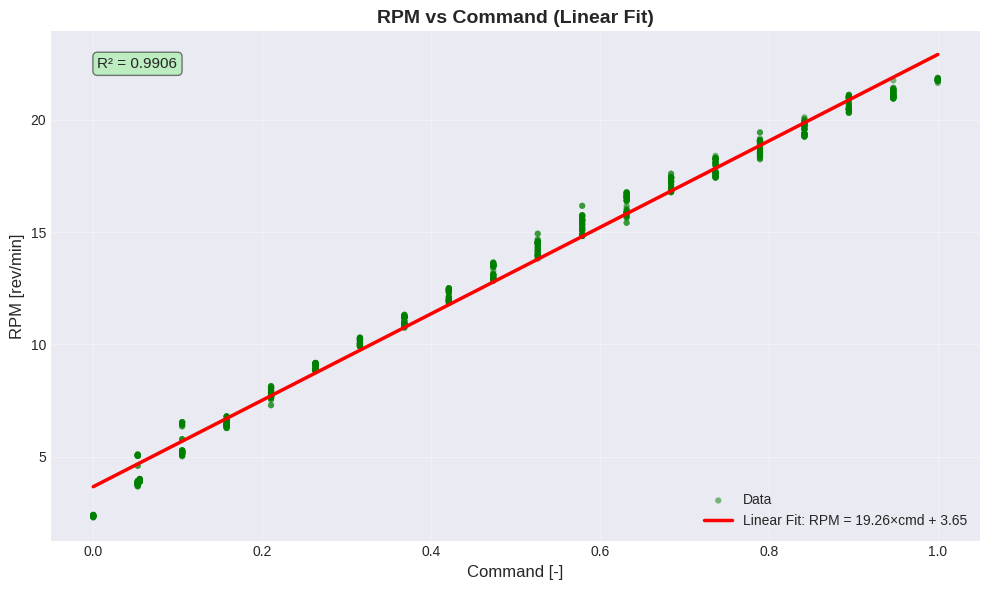


✓ Linear Fit Results:
  RPM = 19.2585 × cmd + 3.6547
  R² = 0.9906
  Saved: rpm_vs_cmd_linear.png/pdf
  ✓ Saved fit data: rpm_vs_cmd_linear_fit.csv


In [73]:
if df_fit is not None:
    # Linear fit: RPM = a * cmd + b
    coeffs_rpm = np.polyfit(df_fit['cmd'], df_fit[rpm_col], 1)
    a_rpm, b_rpm = coeffs_rpm
    
    # Generate fitted line
    cmd_range = np.linspace(df_fit['cmd'].min(), df_fit['cmd'].max(), 100)
    rpm_fit_linear = a_rpm * cmd_range + b_rpm
    
    # Calculate R²
    rpm_pred = a_rpm * df_fit['cmd'] + b_rpm
    ss_res = np.sum((df_fit[rpm_col] - rpm_pred)**2)
    ss_tot = np.sum((df_fit[rpm_col] - df_fit[rpm_col].mean())**2)
    r2_rpm = 1 - (ss_res / ss_tot)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(df_fit['cmd'], df_fit[rpm_col], alpha=0.5, s=20, 
               c='green', edgecolors='none', label='Data')
    ax.plot(cmd_range, rpm_fit_linear, 'r-', linewidth=2.5, 
            label=f'Linear Fit: RPM = {a_rpm:.2f}×cmd + {b_rpm:.2f}')
    
    ax.set_xlabel('Command [-]', fontsize=12)
    ax.set_ylabel('RPM [rev/min]', fontsize=12)
    ax.set_title('RPM vs Command (Linear Fit)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add R² text
    ax.text(0.05, 0.95, f'R² = {r2_rpm:.4f}', 
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(output_dir / 'rpm_vs_cmd_linear.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'rpm_vs_cmd_linear.pdf', bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Linear Fit Results:")
    print(f"  RPM = {a_rpm:.4f} × cmd + {b_rpm:.4f}")
    print(f"  R² = {r2_rpm:.4f}")
    print(f"  Saved: rpm_vs_cmd_linear.png/pdf")
    
    # Export data with fit
    df_export = pd.DataFrame({
        'cmd': cmd_range,
        'rpm_fitted': rpm_fit_linear
    })
    df_export.to_csv(output_dir / 'rpm_vs_cmd_linear_fit.csv', index=False)
    print(f"  ✓ Saved fit data: rpm_vs_cmd_linear_fit.csv")

### 5.3 Thrust vs Command

Direct relationship between thrust and command (for comparison).

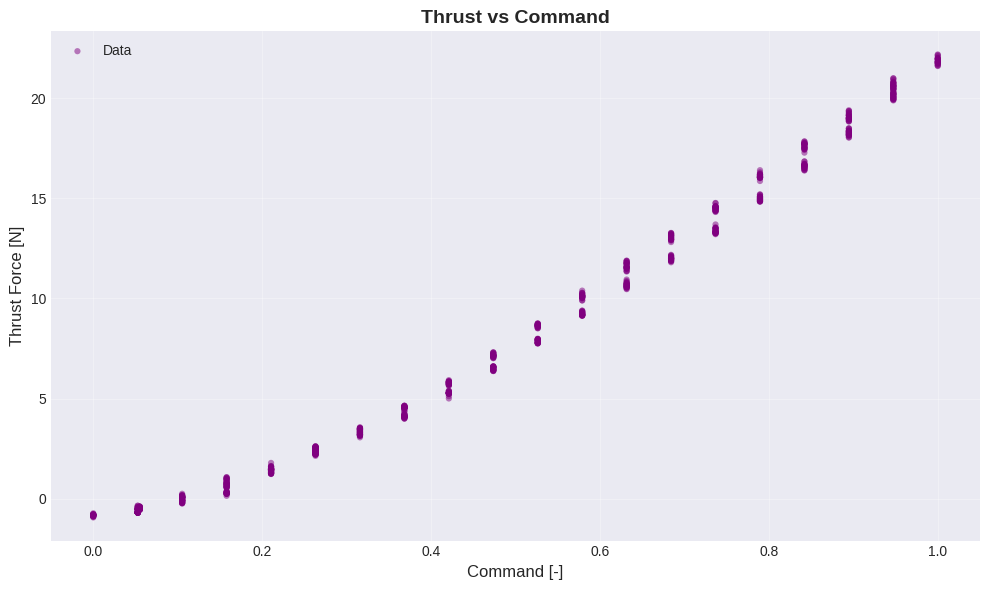


✓ Saved: thrust_vs_cmd.png/pdf
  ✓ Saved data: thrust_vs_cmd_data.csv


In [74]:
if df_fit is not None:
    # Plot Thrust vs Command
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(df_fit['cmd'], df_fit['force_z_N'], alpha=0.5, s=20, 
               c='purple', edgecolors='none', label='Data')
    
    ax.set_xlabel('Command [-]', fontsize=12)
    ax.set_ylabel('Thrust Force [N]', fontsize=12)
    ax.set_title('Thrust vs Command', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'thrust_vs_cmd.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'thrust_vs_cmd.pdf', bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Saved: thrust_vs_cmd.png/pdf")
    
    # Export raw data
    df_export = df_fit[['cmd', 'force_z_N']].copy()
    df_export = df_export.sort_values('cmd')
    df_export.to_csv(output_dir / 'thrust_vs_cmd_data.csv', index=False)
    print(f"  ✓ Saved data: thrust_vs_cmd_data.csv")

### 5.4 Summary of Fitted Models

Display all fitted equations and coefficients.

In [75]:
if df_fit is not None:
    print("\n" + "="*80)
    print("FITTED MODELS SUMMARY")
    print("="*80)
    
    print("\n📐 1. Thrust vs RPM (Quadratic Fit):")
    print(f"   Thrust [N] = {a_thrust:.8e} × RPM² + {b_thrust:.8f} × RPM + {c_thrust:.4f}")
    print(f"   R² = {r2_thrust:.4f}")
    
    print("\n📐 2. RPM vs Command (Linear Fit):")
    print(f"   RPM = {a_rpm:.4f} × cmd + {b_rpm:.4f}")
    print(f"   R² = {r2_rpm:.4f}")
    
    print("\n💡 Combined Model (Thrust from Command):")
    print("   Step 1: Calculate RPM from command using linear fit")
    print("   Step 2: Calculate Thrust from RPM using quadratic fit")
    
    # Save coefficients to CSV
    coeffs_df = pd.DataFrame({
        'Model': ['Quadratic: Thrust vs RPM', 'Quadratic: Thrust vs RPM', 'Quadratic: Thrust vs RPM',
                  'Linear: RPM vs Cmd', 'Linear: RPM vs Cmd'],
        'Coefficient': ['a (RPM²)', 'b (RPM)', 'c (constant)',
                       'a (slope)', 'b (intercept)'],
        'Value': [a_thrust, b_thrust, c_thrust, a_rpm, b_rpm],
        'R_squared': [r2_thrust, '', '', r2_rpm, '']
    })
    coeffs_file = output_dir / 'fitted_coefficients.csv'
    coeffs_df.to_csv(coeffs_file, index=False)
    print(f"\n✓ Saved coefficients to: {coeffs_file}")
    
    print("\n" + "="*80)


FITTED MODELS SUMMARY

📐 1. Thrust vs RPM (Quadratic Fit):
   Thrust [N] = 5.14747846e-02 × RPM² + -0.09023580 × RPM + -0.9959
   R² = 0.9972

📐 2. RPM vs Command (Linear Fit):
   RPM = 19.2585 × cmd + 3.6547
   R² = 0.9906

💡 Combined Model (Thrust from Command):
   Step 1: Calculate RPM from command using linear fit
   Step 2: Calculate Thrust from RPM using quadratic fit

✓ Saved coefficients to: data/fitted_coefficients.csv



## 6. Analysis Complete - Summary

All plots and data files have been generated and saved.

In [76]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\nOutput directory: {output_dir}")

print("\n📊 CSV Files for LaTeX Plotting:")
print(f"  1. thrust_map_raw_data.csv              - Full raw dataset")
if df_fit is not None:
    print(f"  2. thrust_vs_rpm_quadratic_fit.csv      - Thrust vs RPM (quadratic curve)")
    print(f"  3. rpm_vs_cmd_linear_fit.csv            - RPM vs Command (linear curve)")
    print(f"  4. thrust_vs_cmd_data.csv               - Thrust vs Command (scatter data)")
    print(f"  5. fitted_coefficients.csv              - All model coefficients")

print("\n📈 Plot Files (PNG + PDF):")
print(f"  1. verification_all_vs_cmd.png/pdf      - Data verification")
if df_fit is not None:
    print(f"  2. thrust_vs_rpm_quadratic.png/pdf      - Thrust vs RPM + quadratic fit")
    print(f"  3. rpm_vs_cmd_linear.png/pdf            - RPM vs Command + linear fit")
    print(f"  4. thrust_vs_cmd.png/pdf                - Thrust vs Command scatter")

print("\n💡 For LaTeX pgfplots:")
print("  - thrust_vs_rpm_quadratic_fit.csv: columns [rpm, thrust_N_fitted]")
print("  - rpm_vs_cmd_linear_fit.csv: columns [cmd, rpm_fitted]")
print("  - thrust_vs_cmd_data.csv: columns [cmd, force_z_N]")
print("  - fitted_coefficients.csv: all model parameters")
print("\n" + "="*80)


ANALYSIS COMPLETE!

Output directory: data

📊 CSV Files for LaTeX Plotting:
  1. thrust_map_raw_data.csv              - Full raw dataset
  2. thrust_vs_rpm_quadratic_fit.csv      - Thrust vs RPM (quadratic curve)
  3. rpm_vs_cmd_linear_fit.csv            - RPM vs Command (linear curve)
  4. thrust_vs_cmd_data.csv               - Thrust vs Command (scatter data)
  5. fitted_coefficients.csv              - All model coefficients

📈 Plot Files (PNG + PDF):
  1. verification_all_vs_cmd.png/pdf      - Data verification
  2. thrust_vs_rpm_quadratic.png/pdf      - Thrust vs RPM + quadratic fit
  3. rpm_vs_cmd_linear.png/pdf            - RPM vs Command + linear fit
  4. thrust_vs_cmd.png/pdf                - Thrust vs Command scatter

💡 For LaTeX pgfplots:
  - thrust_vs_rpm_quadratic_fit.csv: columns [rpm, thrust_N_fitted]
  - rpm_vs_cmd_linear_fit.csv: columns [cmd, rpm_fitted]
  - thrust_vs_cmd_data.csv: columns [cmd, force_z_N]
  - fitted_coefficients.csv: all model parameters

